In [29]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [863]:
df = pd.read_csv('default_data_all_variables.csv')
target = pd.read_csv('targets.csv')

In [1049]:
target = target[['home_win_odds','draw_odds','away_win_odds']]

In [1041]:
df = df.loc[:, ~df.columns.str.contains('HomeTeam|AwayTeam')]

In [1055]:
X_train = df[:-300]
y_train = target[:-300]
X_val = df[-300:-150]
y_val = target[-300:-150]
X_test = df[-150:]
y_test = target[-150:]


In [819]:
! pip install xgboost

In [115]:
import sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from sklearn.base import BaseEstimator, RegressorMixin

class KerasRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, build_fn, **kwargs):
        self.build_fn = build_fn
        self.kwargs = kwargs
        self.model = None
    
    def fit(self, X, y, **fit_params):
        self.model = self.build_fn(**self.kwargs)
        self.model.fit(X, y, **fit_params)
        return self
    
    def predict(self, X):
        return self.model.predict(X)
    
    def score(self, X, y):
        return self.model.evaluate(X, y)



In [123]:
def create_model(neurons=128, learning_rate=0.001, dropout_rate=0.2, optimizer='adam'):
    model = Sequential()
    model.add(Dense(neurons, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(3, activation='softmax'))  # Assuming 3 output variables

    # Compile the model with the chosen optimizer
    opt = None
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate)

    model.compile( loss='mse', metrics=['mae'])
    
    return model

from sklearn.model_selection import RandomizedSearchCV

# Define the hyperparameters to tune
param_dist = {
    'neurons': [64, 128, 256],           # Number of neurons in the hidden layers
    'learning_rate': [0.1, 0.01, 0.001], # Learning rate
    'dropout_rate': [0.1, 0.2, 0.3, 0.5],# Dropout rate
    'optimizer': ['adam', 'rmsprop', 'sgd'], # Optimizer type
    'batch_size': [32, 64, 128],         # Batch size
    'epochs': [50, 100, 150]             # Number of epochs
}

# Wrap the Keras model with KerasRegressor (for regression tasks)
model = KerasRegressor(build_fn=create_model, verbose=0)

random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, 
                                   n_iter=10, cv=3, verbose=1, n_jobs=-1)

# Fit the random search model
random_search_result = random_search.fit(X_train, y_train)

best_model = random_search_result.best_estimator_.model
test_loss, test_mae = best_model.evaluate(X_test, y_test)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


ValueError: Invalid parameter 'optimizer' for estimator KerasRegressor(build_fn=<function create_model at 0x00000208DD7A4A40>). Valid parameters are: ['build_fn'].

In [1057]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
# Define the optimizer with a specific learning rate
optimizer = Adam(learning_rate=0.001)
model = Sequential()

# Input layer
model.add(Dense(256, activation='relu', input_shape=(168,)))  # 278 is the number of input features
model.add(Dropout(0.1))
# Hidden layers
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))  # Optional, to prevent overfitting
# model.add(Dense(138, activation='relu'))
# model.add(Dropout(0.1))  # Optional, to prevent overfitting
model.add(Dense(32, activation='relu'))

# Output layer (with softmax to ensure sum-to-1 constraint)
model.add(Dense(3, activation='softmax'))

# Compile the model
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10)
class_weights = {'home_win_odds': 1.0, 'draw_odds': 1, 'away_win_odds': 2000.0}
# Train the model
history = model.fit(X_train, y_train, epochs=1000, batch_size=2048, validation_data=(X_val, y_val), class_weight=class_weights, callbacks=[early_stopping])
# , callbacks=[early_stopping]
# Evaluate the model
results = model.evaluate(X_test, y_test)

Epoch 1/1000


C:\Users\ciesl\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.1902 - mae: 0.1119 - val_loss: 0.1794 - val_mae: 0.0995
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1757 - mae: 0.0971 - val_loss: 0.1690 - val_mae: 0.0990
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1652 - mae: 0.0939 - val_loss: 0.1597 - val_mae: 0.1020
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1554 - mae: 0.0927 - val_loss: 0.1498 - val_mae: 0.1014
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1458 - mae: 0.0919 - val_loss: 0.1407 - val_mae: 0.1009
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1364 - mae: 0.0914 - val_loss: 0.1319 - val_mae: 0.0997
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1278 - mae: 0.0919 - val_loss: 0.1234 - val_mae: 0.0989
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1195 - mae: 0.0909 - val_loss: 0.1159 - val_mae: 0.0994
Epoch 9/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1124 - mae: 0.09

In [1053]:
y_train

,FTHG,FTAG,home_win_odds,draw_odds,away_win_odds
0,4,3,0.641468,0.213116,0.145416
1,0,2,0.094400,0.178967,0.726633
2,2,3,0.779960,0.151404,0.068636
3,0,3,0.527137,0.271747,0.201116
4,1,0,0.566987,0.258239,0.174774
...,...,...,...,...,...
5745,1,2,0.332255,0.274333,0.393412
5746,2,1,0.204925,0.261120,0.533955
5747,1,1,0.535405,0.252177,0.212418
5748,2,2,0.279918,0.272475,0.447607


In [1059]:
results

[0.020503049716353416, 0.10132663697004318]

In [1061]:
y_pred = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [1063]:
y_pred

array([[0.4534368 , 0.24297908, 0.30358413],
       [0.4360613 , 0.2775998 , 0.28633887],
       [0.45497292, 0.24556446, 0.2994626 ],
       [0.39920583, 0.28260696, 0.31818724],
       [0.40844277, 0.27934057, 0.31221667],
       [0.42860907, 0.2802407 , 0.29115018],
       [0.42589405, 0.27881882, 0.29528704],
       [0.42455903, 0.27799287, 0.2974481 ],
       [0.39940378, 0.27796328, 0.3226329 ],
       [0.40865022, 0.28227898, 0.30907086],
       [0.43149656, 0.2746766 , 0.29382682],
       [0.4104877 , 0.28098604, 0.30852616],
       [0.40107822, 0.28010646, 0.31881535],
       [0.41289338, 0.24301927, 0.3440873 ],
       [0.42714867, 0.23970172, 0.33314955],
       [0.47172913, 0.23915552, 0.28911534],
       [0.4709469 , 0.23642021, 0.2926329 ],
       [0.41451934, 0.24443728, 0.34104338],
       [0.4621954 , 0.24236567, 0.29543892],
       [0.437762  , 0.24289748, 0.3193405 ],
       [0.39977655, 0.27897164, 0.32125178],
       [0.51733744, 0.23181401, 0.25084853],
       [0.

In [77]:
target[-150:]

,FTHG,FTAG,home_win_odds,draw_odds,away_win_odds
5900,2,0,0.134539,0.193082,0.672379
5901,2,3,0.424772,0.260270,0.314958
5902,0,4,0.143382,0.193517,0.663101
5903,4,0,0.179575,0.213786,0.606640
5904,1,1,0.418944,0.283305,0.297751
...,...,...,...,...,...
6045,1,1,0.712907,0.170303,0.116789
6046,1,1,0.592215,0.217852,0.189933
6047,2,1,0.385471,0.240114,0.374415
6048,0,3,0.253574,0.227835,0.518591


In [1067]:
import xgboost as xgb
model = xgb.XGBRegressor(n_estimators = 200, eta = 0.1, max_depth = 30, min_child_weight = 3, booster = 'dart', tree_method = 'hist')
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster='dart', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=30,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [1068]:
predictions = model.predict(X_test)
softmax_predictions = softmax(predictions.reshape(-1, 3))
predictions_sum = predictions.sum(axis =1).reshape(-1, 1)
predictions/=predictions_sum
predictions

array([[0.4017916 , 0.2384135 , 0.35979486],
       [0.37923703, 0.2792056 , 0.34155744],
       [0.47799814, 0.24692059, 0.2750812 ],
       [0.45084858, 0.26319999, 0.2859514 ],
       [0.3655037 , 0.29044643, 0.3440499 ],
       [0.41411948, 0.28238928, 0.30349126],
       [0.41399977, 0.27761966, 0.30838063],
       [0.40191686, 0.2785327 , 0.31955037],
       [0.4062552 , 0.29487038, 0.2988745 ],
       [0.35113996, 0.26873899, 0.380121  ],
       [0.36240548, 0.2785346 , 0.35905996],
       [0.3792451 , 0.2913488 , 0.32940614],
       [0.42167887, 0.26420292, 0.31411815],
       [0.26648158, 0.25230822, 0.48121017],
       [0.39671692, 0.21344113, 0.38984197],
       [0.50744957, 0.22373104, 0.26881945],
       [0.51754546, 0.19842078, 0.2840337 ],
       [0.31717587, 0.2547125 , 0.42811158],
       [0.35159492, 0.29174396, 0.35666108],
       [0.4281967 , 0.26946834, 0.302335  ],
       [0.38671076, 0.2716853 , 0.34160393],
       [0.5253752 , 0.20986949, 0.2647553 ],
       [0.

In [1069]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, predictions)

0.10422470013438462

In [1070]:
pred_df = pd.DataFrame(predictions, columns = ['home_win_odds', 'draw_odds', 'away_win_odds'])
pred_df[['FTHG', 'FTAG']] = trg[['FTHG', 'FTAG']]
pred_df['probability converted'] = pred_df.apply(choose_value, axis=1)
pred_df['probability converted'].sum()

47.57851344347

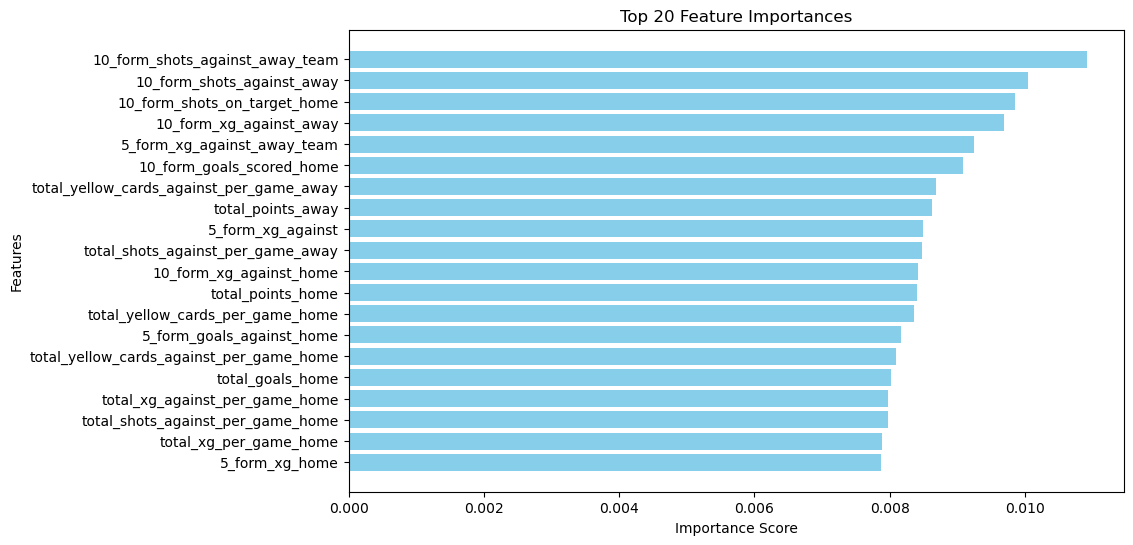

In [1071]:
import matplotlib.pyplot as plt
feature_importances = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame for easier manipulation
feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance and get the top 20 features
top_20_features = feature_importances_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_20_features['Feature'], top_20_features['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

In [971]:
target[-150:]

,FTHG,FTAG,home_win_odds,draw_odds,away_win_odds
5900,2,0,0.134539,0.193082,0.672379
5901,2,3,0.424772,0.260270,0.314958
5902,0,4,0.143382,0.193517,0.663101
5903,4,0,0.179575,0.213786,0.606640
5904,1,1,0.418944,0.283305,0.297751
...,...,...,...,...,...
6045,1,1,0.712907,0.170303,0.116789
6046,1,1,0.592215,0.217852,0.189933
6047,2,1,0.385471,0.240114,0.374415
6048,0,3,0.253574,0.227835,0.518591


In [867]:
trg = target[-150:]

In [871]:
def choose_value(row):
    if row['FTHG'] > row['FTAG']:
        return row['home_win_odds']
    elif row['FTHG'] == row['FTAG']:
        return row['draw_odds']
    else:
        return row['away_win_odds']

# Apply the function to each row
trg['probability converted'] = trg.apply(choose_value, axis=1)

C:\Users\ciesl\AppData\Local\Temp\ipykernel_13620\2918088030.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trg['probability converted'] = trg.apply(choose_value, axis=1)


In [877]:
trg['probability converted'].sum()

65.23541854439682